# Distributed Training: Fine Tune a Pre-trained BERT model for Q&A with SageMaker Distributed Data Parallel Library

The SageMaker distributed data parallel library extends SageMaker training capabilities on deep learning models with near-linear scaling efficiency, achieving fast time-to-train with minimal code changes.

When training a model on a large amount of data, machine learning practitioners often turn to distributed training to reduce the time to train. In some cases, where time is of the essence, the business requirement is to finish training as quickly as possible or at least within a constrained time period. Then, distributed training is scaled to use a cluster of multiple nodes—not just multiple GPUs in a computing instance, but multiple instances with multiple GPUs. As the cluster size increases, so does the significant drop in performance. This drop in performance is primarily caused by the communications overhead between nodes in a cluster.

To resolve such overhead problems, SageMaker offers two distributed training options: SageMaker model parallel and SageMaker data parallel. This guide focuses on how to train models using the SageMaker data parallel library.

* The library optimizes your training job for AWS network infrastructure and Amazon EC2 instance topology.
* The library takes advantage of gradient updates to communicate between nodes with a custom AllReduce algorithm.

SageMaker's distributed data parallel library addresses communications overhead in two ways:

* The library performs AllReduce, a key operation during distributed training that is responsible for a large portion of communication overhead.
* The library performs optimized node-to-node communication by fully utilizing AWS’s network infrastructure and Amazon EC2 instance topology.

Use this data parallel library to increase speed by up to 25% in training models such as BERT. 

In this sample notbook, we will learn about the field of Q&A in NLP — and learn how to fine-tune a pre-trained transformer models for question and answer using SageMaker distributed data parallel library. Here we have three key parts in our data, which are:

* Questions — strings containing the question which we will ask our model
* Contexts — larger segments of text that contain the answers to our questions within them
* Answers — shorter strings which are ‘extracts’ of the given contexts that provide an answer to our questions


## Model
We will be fine tuning the pre-trained [bert-large-uncased-whole-word-masking](https://huggingface.co/bert-large-uncased-whole-word-masking-finetuned-squad) from HuggingFace.
.

## Build your own comtainer image
Amazon SageMaker supports binging your own container method. You may not need to create a container to bring your own code to Amazon SageMaker. When you are using a framework such as PyTorch, Apache MXNet or TensorFlow that has direct support in SageMaker, you can simply supply the Python code that implements your algorithm using the SDK entry points for that framework. This set of supported frameworks is regularly added to, so you should check the current list to determine whether your algorithm is written in one of these common machine learning environments.

Even if there is direct SDK support for your environment or framework, you may find it more effective to build your own container. If the code that implements your algorithm is quite complex, or you need special additions to the framework, building your own container may be the right choice.

Some reasons to build an already supported framework container are:
1. A specific version isn't supported.
2. Configure and install your dependencies and environment.
3. Use a different training/hosting solution than provided. 

## Dataset
we will use the Stanford Question Answering Dataset (SQuAD) 2.0. Our model will be expected to correctly select the specific part of a text segment that answers a question we provide.

## Platform
This notebook runs on pytorch 1.11.x kernel on Nividia cuda1.15 with SageMaker training toolkit. We use a purposely built container which contains SageMaker distributed libraries, NCCL and OpenMPI plus EFA libraries to run on GPU instance(s).

This notebook should run on any type of AWS instances with Nvidia GPU acceletors. 

## Pre-requisites: train your own container

### Dockerfile

The Dockerfile describes the image that we want to build. You can think of it as describing the complete operating system installation of the system that you want to run. A Docker container running is quite a bit lighter than a full operating system, however, because it takes advantage of Linux on the host machine for the basic operations.

For the Python science stack, we start from an official TensorFlow docker image and run the normal tools to install TensorFlow Serving. Then we add the code that implements our specific algorithm to the container and set up the right environment for it to run under.

Let's look at the Dockerfile for this example.


In [ ]:
!cat container/Dockerfile.torch111.cu115

### Building and registering the container
The following shell code shows how to build the container image using docker build and push the container image to ECR using docker push. This code is also available as the shell script container/build-and-push.sh, which you can run as build-and-push.sh sagemaker-tf-cifar10-example to build the image sagemaker-tf-cifar10-example.

This code looks for an ECR repository in the account you're using and the current default region (if you're using a SageMaker notebook instance, this is the region where the notebook instance was created). If the repository doesn't exist, the script will create it.

```
%%sh

# The name of our algorithm
algorithm_name=sagemaker-tf-cifar10-example

cd container

chmod +x cifar10/train
chmod +x cifar10/serve

account=$(aws sts get-caller-identity --query Account --output text)

# Get the region defined in the current configuration (default to us-west-2 if none defined)
region=$(aws configure get region)
region=${region:-us-west-2}

fullname="${account}.dkr.ecr.${region}.amazonaws.com/${algorithm_name}:latest"

# If the repository doesn't exist in ECR, create it.

aws ecr describe-repositories --repository-names "${algorithm_name}" > /dev/null 2>&1

if [ $? -ne 0 ]
then
    aws ecr create-repository --repository-name "${algorithm_name}" > /dev/null
fi

# Get the login command from ECR and execute it directly
#$(aws ecr get-login --region ${region} --no-include-email)
aws ecr get-login-password --region ${region}| docker login --username AWS --password-stdin ${fullname}

# Build the docker image locally with the image name and then push it to ECR
# with the full name.

docker build  -t ${algorithm_name} . -f Dockerfile.cpu
docker tag ${algorithm_name} ${fullname}

docker push ${fullname}
```

## Setup SageMaker environment

_If you are going to use Sagemaker in a local environment. You need access to an IAM Role with the required permissions for Sagemaker. You can find [here](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html) more about it._

In [ ]:
!pip install -U --no-cache-dir transformers>=4.18.0 

In [ ]:
import logging
import transformers
import sagemaker

logger = logging.getLogger('__name__')
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler())
logger.info(f'Using SageMaker version: {sagemaker.__version__}')
logger.info(f'Using Transfomer version: {transformers.__version__}')


sess = sagemaker.Session()
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

role = sagemaker.get_execution_role()
sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

Sagemaker is providing useful properties about the training environment through various environment variables, including the following:

* `SM_MODEL_DIR`: A string that represents the path where the training job writes the model artifacts to. After training, artifacts in this directory are uploaded to S3 for model hosting.

* `SM_NUM_GPUS`: An integer representing the number of GPUs available to the host.

* `SM_CHANNEL_XXXX:` A string that represents the path to the directory that contains the input data for the specified channel. For example, if you specify two input channels in the HuggingFace estimator’s fit call, named `train` and `test`, the environment variables `SM_CHANNEL_TRAIN` and `SM_CHANNEL_TEST` are set.


To run your training job locally you can define `instance_type='local'` or `instance_type='local_gpu'` for gpu usage. _Note: this does not working within SageMaker Studio_

## Creating an Estimator and start a training job

In this example we are going to use the capability to download/use a fine-tuning script from a `git`- repository. We are using the `run_qa.py` from the `transformers` example scripts. You can find the code [here](https://github.com/huggingface/transformers/tree/master/examples/question-answering).


### NLP Tokenizer

Tokenization is the process of breaking a stream of textual data into words, terms, sentences, symbols, or some other meaningful elements called tokens. These tokens help in understanding the context or developing the model for the NLP. The tokenization helps in interpreting the meaning of the text by analyzing the sequence of the words. This immediately turns an unstructured string (text document) into a numerical data structure suitable for machine learning. 

BERT based NLP tokenizer embeds input sentence based on token, sentence and position embedding, as the followinh examples shows.

```
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(//path to tokenizers)
sample = 'where is Himalayas in the world map?'
encoding = tokenizer.encode(sample)
print(encoding)
print(tokenizer.convert_ids_to_tokens(encoding))output 1: [101, 2073, 2003, 26779, 1999, 1996, 2088, 4949, 1029, 102]
output 2: ['[CLS]', 'where', 'is', 'himalayas', 'in', 'the', 'world', 'map', '?', '[SEP]']
```


In [ ]:
from transformers import AutoTokenizer

# tokenizer used in preprocessing
tokenizer_name = 'bert-large-uncased-whole-word-masking'
#tokenizer_name = 'roberta-large'

# download tokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

### Distributed Training with Parameter Servers
A common pattern in distributed training is to use dedicated processes to collect gradients computed by “worker” processes, then aggregate them and distribute the updated gradients back to the workers. These processes are known as parameter servers. In general, they can be run either on their own machines or co-located on the same machines as the workers. In a parameter server cluster, each parameter server communicates with all workers (“all-to-all”). The Amazon SageMaker prebuilt TensorFlow container comes with a built-in option to use parameter servers for distributed training. The container runs a parameter server thread in each training instance, so there is a 1:1 ratio of parameter servers to workers. With this built-in option, gradient updates are made asynchronously (though some other versions of parameters servers use synchronous updates).

* Addresses communications: speed up to 25% of trainin time on BERT
    1.  AllReduce, a key operation during distributed training that is responsible for a large portion of communication overhead.
    2.  Optimized node-to-node communication by fully utilizing AWS’s network infrastructure and Amazon EC2 instance topology.
* Balanced Fusion Buffer: a new technique called balanced fusion buffers to make optimal use of the bandwidth available across all nodes in the cluster
* Depends on OpenMPI or Message Passing Interface, a standardized API typically used for parallel and/or distributed computing and NCCL, the NVIDIA Collective Communication Library (NCCL) implements multi-GPU and multi-node communication primitives optimized for NVIDIA GPUs and Networking.
* SSH handles intra-node communication.
* Works with EFA for higher networking bandwidth and FSx for higher I/O T-put.

The high-level workflow of the SageMaker distributed data parallel library is as following:

1. The library assigns ranks to GPUs (workers).
2. At each iteration, the library divides each global batch by the total number of workers (world size) and assigns small batches (batch shards) to the workers.
    * The size of the global batch is (number of nodes in a cluster) * (number of GPUs per node) * (per batch shard).
    * A batch shard (small batch) is a subset of dataset assigned to each GPU (worker) per iteration.

3. The library launches a training script on each work
4. The library manages copies of model weights and gradients from the workers at the end of every iteration.
5. The library synchronizes model weights and gradients across the workers to aggregate a single trained model.

The following architecture diagram shows an example of how the library sets up data parallelism for a cluster of 3 nodes.
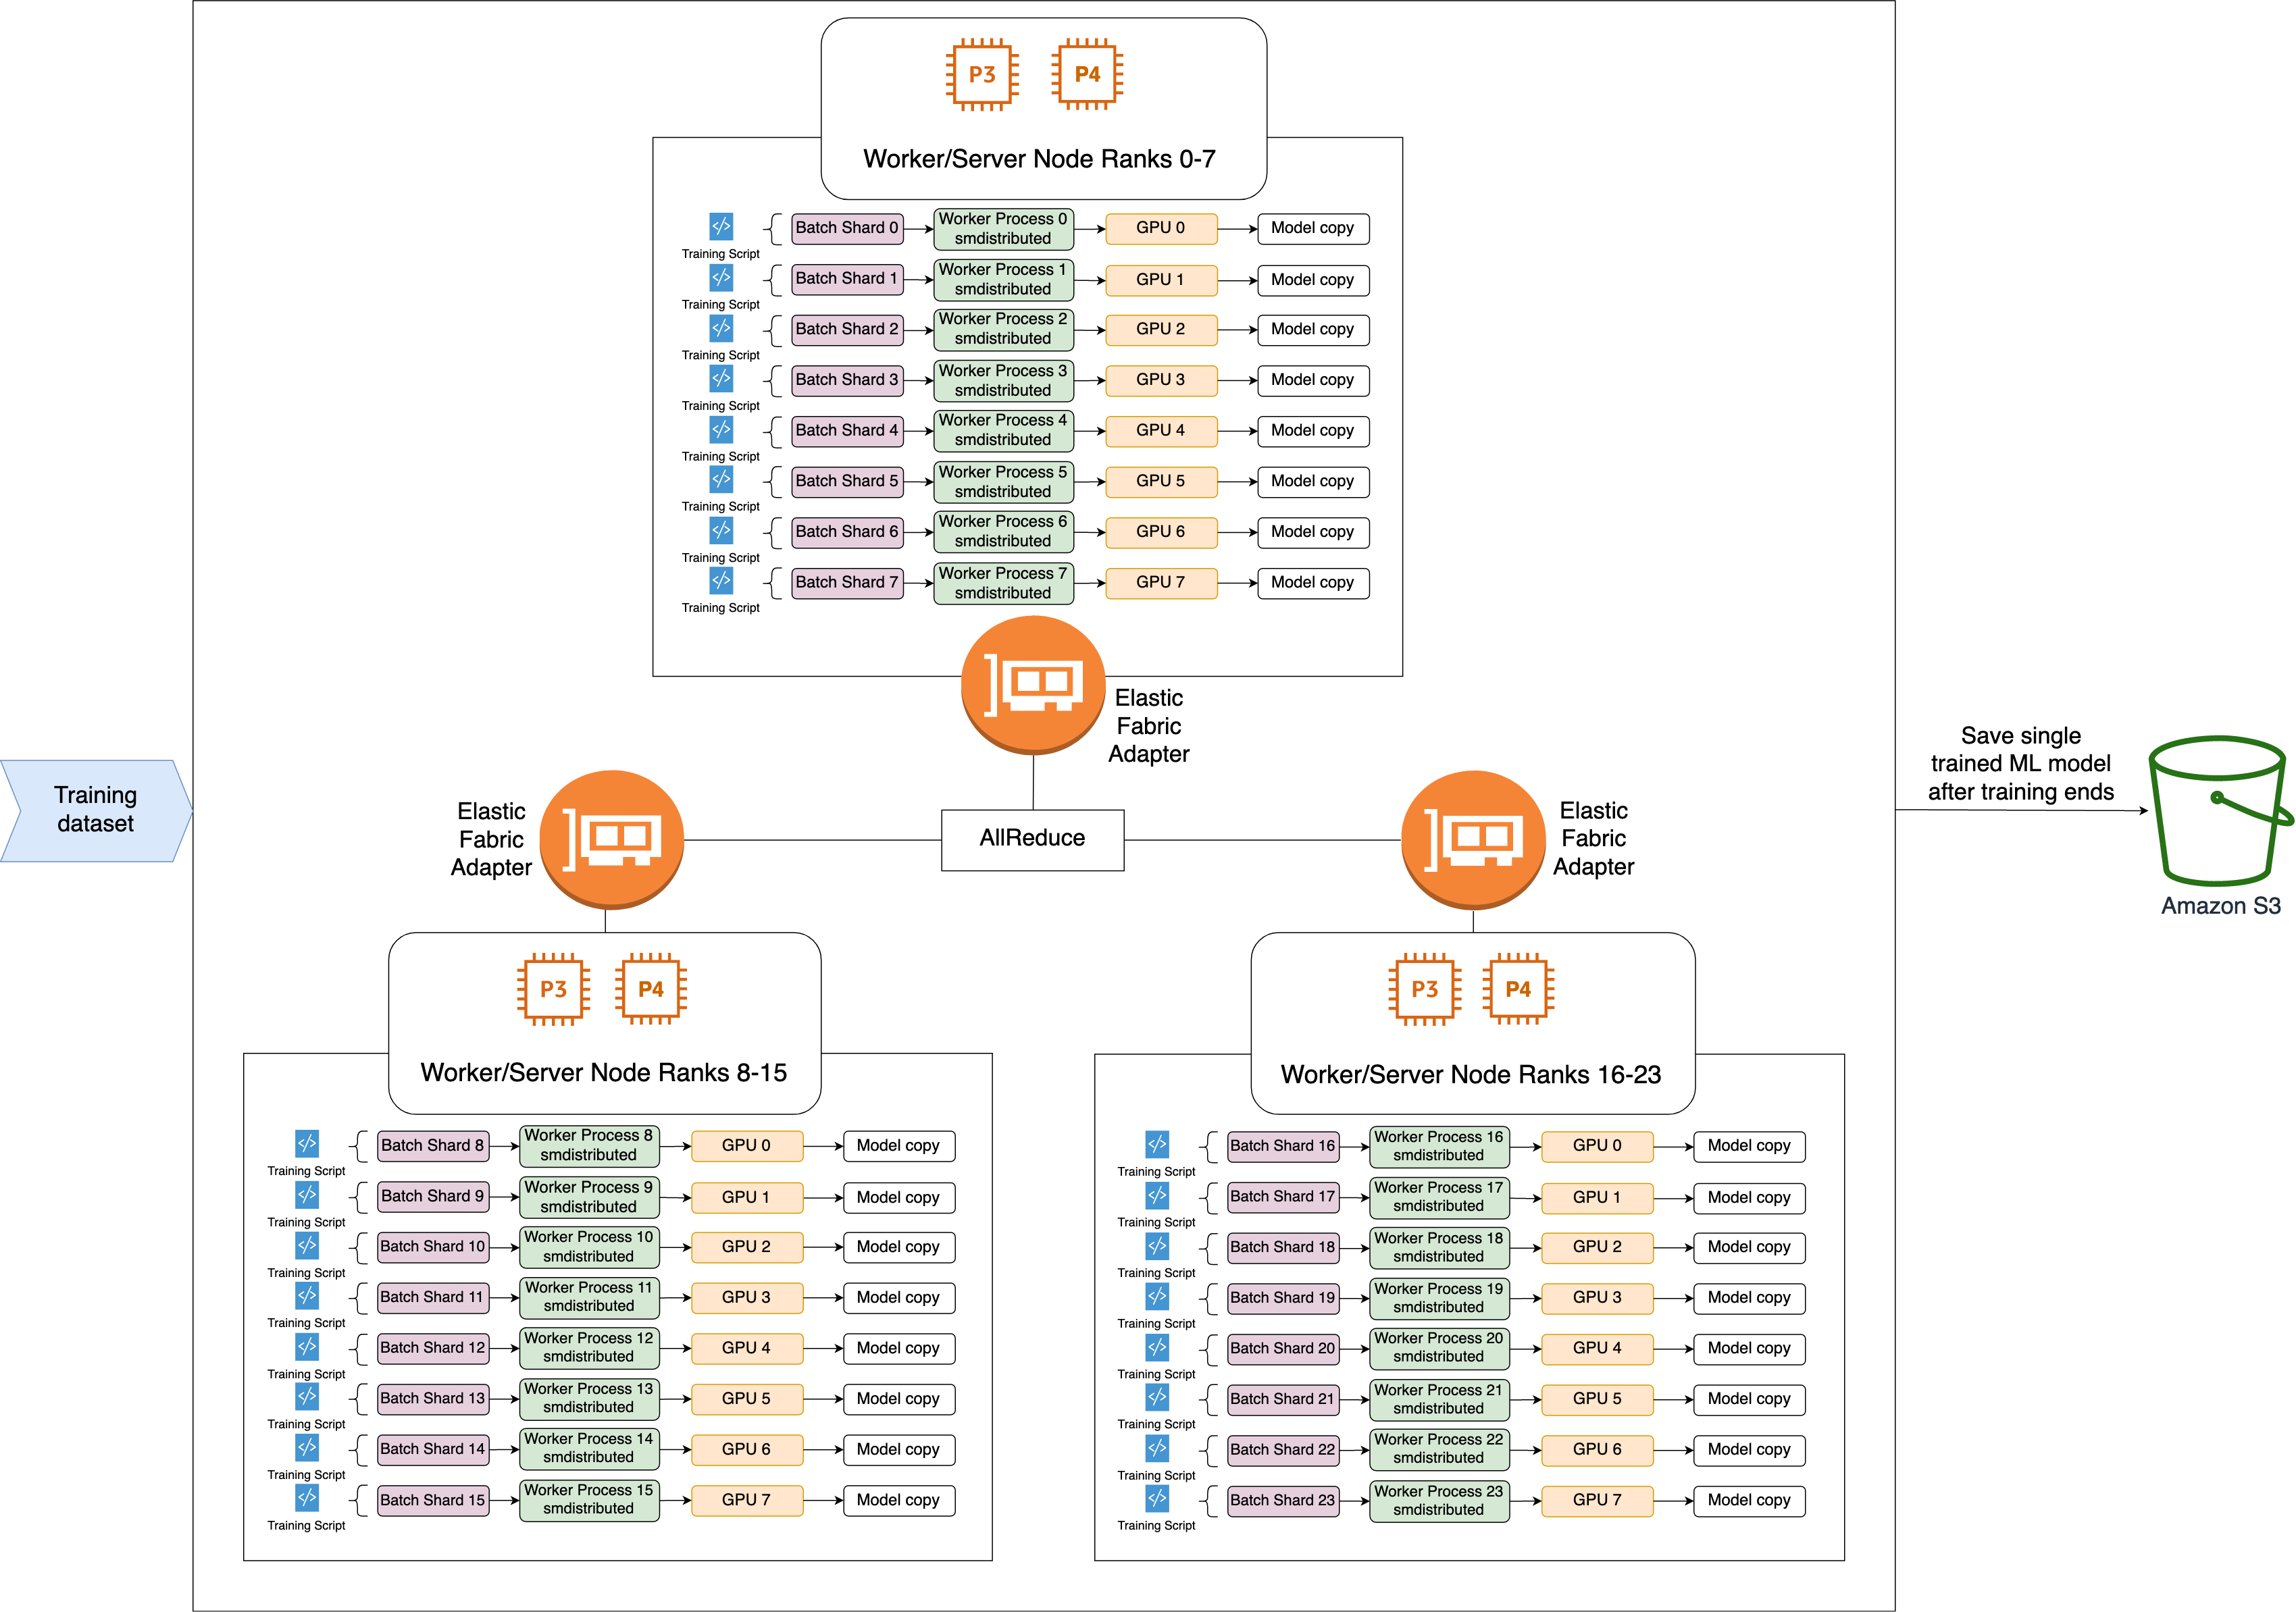


### DDP Configurations:
SageMaker’s distributed data parallel library extends SageMaker’s training capabilities on deep learning models with near-linear scaling efficiency, achieving fast time-to-train with minimal code changes.

* Optimizes your training job for AWS network infrastructure and EC2 instance topology.
* Takes advantage of gradient update to communicate between nodes with a custom AllReduce algorithm.
* You must provide TensorFlow / PyTorch training scripts that are adapted to use the distributed data parallel library.
* Your input data must be in an S3 bucket or in FSx in the AWS region that you will use to launch your training job. 

#### Common parameters in smdistributed libraries:

As to your question: processes are the actual instances of the program that are running. MPI allows you to create logical groups of processes, and in each group, a process is identified by its rank. This is an integer in the range [0, N-1] where N is the size of the group. Communicators are objects that handle communication between processes. An intra-communicator handles processes within a single group, while an inter-communicator handles communication between two distinct groups. Communications can be either of two types :

* Point-to-Point : Two processes in the same communicator are going to communicate.
* Collective : All the processes in a communicator are going to communicate together.

By default, you have a single group that contains all your processes, and the intra-communicator MPI_COMM_WORLD that handles communication between them. This is sufficient for most applications, and does blur the distinction between process and rank a bit. The main thing to remember is that the rank of a process is always relative to a group. If you were to split your processes into two groups (e.g. one group to read input and another group to process data), then each process would now have two ranks: the one it originally had in MPI_COMM_WORLD, and one in its new group.

* RANK: unique number to identify a comminicator;
* WORLD_SIZE: total number of the communicators in a MPI_COMM_WORLD.
* Mini-batchs:splits in a micro-batch to increase parallelism


#### Allreduce (or MPI) vs. Parameter server 
A server manager  maintains a consistent view of the metadata of the servers, such as node liveness and the assignment of parameter partitions. Parameter servers in the server group partition keys using consistent hashing with virtual nodes. Besides, each server node stores a replica of the k counterclockwise neighbor key ranges relative to the one it owns.

A ring allreduce is an algorithm for which the communication cost is constant and independent of the number of GPUs in the system, and is determined solely by the slowest connection between GPUs in the system; in fact, if you only consider bandwidth as a factor in your communication cost (and ignore latency), the ring allreduce is an optimal communication algorithm. In addition, allreduce allows you to overlap the transmission of gradient. 

In general, parameter server works better if you have a large number of unreliable and not so powerful machine. AllReduce works better if you have a small amount of fast devices(variance of step time between each device is small) run in a controlled environment with strong connected links. 

#### Tips and pitfalls

* Avoid CPU bottelneck: SageMaker distributed data parallel uses the CPU for AllReduce operations. Try to use GPUs or by completing all preprocessing before training.
* Use multiple nodes: The library’s AllReduce operation gives you significant performance improvement. Also, on a single host, NVLink already contributes to in-node AllReduce efficiency.
* Use Amazon SageMaker Debugger: To monitor and visualize CPU and GPU utilization and other metrics of interest during training.
* Increase batch sizes proportionally with training nodes: To improve convergence speed as you add more nodes to your training job and increase the global batch size, increase the learning rate.
* Customize MPI options: You can set custom MPI operations using the custom_mpi_options parameter in the Estimator. Any mpirun flags passed in this field are added to the mpirun command and executed by SageMaker for training. 
* Increase T-put by using Amazon FSx and set up an optimal storage and throughput capacity.


In [ ]:
from sagemaker.estimator import Estimator

# Instance storage configurations
volume_size=200 # Size in GB of the EBS volume to use for storing input data during training (default: 30). 

# configuration for running training on smdistributed Data Parallel
dp_options = {
    "enabled":True,
    "custom_mpi_options": "-verbose -x NCCL_DEBUG=VERSION",
    #"parameters": {
    #    "microbatches": 4,
    #}
}

# configuration for running training on smdistributed Data Parallel
ddp_distribution = {
    'smdistributed':{'dataparallel': dp_options}, 
    'parameter_server':{'enabled': False}, # or False
}

# metric definition to extract the results
metric_definitions=[
     {"Name": "train_runtime", "Regex": "train_runtime.*=\D*(.*?)$"},
     {'Name': 'train_samples_per_second', 'Regex': "train_samples_per_second.*=\D*(.*?)$"},
     {'Name': 'epoch', 'Regex': "epoch.*=\D*(.*?)$"},
     {'Name': 'f1', 'Regex': "f1.*=\D*(.*?)$"},
     {'Name': 'exact_match', 'Regex': "exact_match.*=\D*(.*?)$"}]

## Alternatively, here is the configuration for running training on smdistributed Model Parallel

```
mpi_options = {
    "enabled" : True,
    "processes_per_host" : 4,
    "custom_mpi_options": "-verbose", #To avoid Docker warnings from contaminating your training logs,
}

smp_options = {
    "enabled":True,
    "parameters": {
        "microbatches": 4,  # Mini-batchs are split in micro-batch to increase parallelism
        "placement_strategy": "spread",
        "pipeline": "interleaved",
        "optimize": "speed",
        "partitions": 4, # we'll partition the model among the 4 CPUs
        "ddp": True,
    },
    "parameter_server": {
        "enabled": True
    }
}


dmp_distribution={
    "smdistributed": {"modelparallel": smp_options},
    "mpi": mpi_options
}
```

In [ ]:
import json
def json_encode_hyperparameters(hyperparameters):
    return {str(k): json.dumps(v) for (k, v) in hyperparameters.items()}

In [ ]:
hyperparameters_json=json_encode_hyperparameters({
    'model_name_or_path': tokenizer_name,
    'dataset_name':'squad',
    'do_train': True,
    'do_eval': True,
    'fp16': True,
    'per_device_train_batch_size': 4,
    'per_device_eval_batch_size': 4,
    'num_train_epochs': 2,
    'max_seq_length': 384,
    'max_steps': 100,
    'pad_to_max_length': True,
    'doc_stride': 128,
    'output_dir': '/opt/ml/model',
})

In [ ]:
import boto3
session = boto3.session.Session()

ecr_image_smddp141 = '763104351884.dkr.ecr.{}.amazonaws.com/pytorch-training:1.11.0-gpu-py38-cu113-ubuntu20.04-sagemaker'.format(session.region_name)
ecr_image_smddp140 = '763104351884.dkr.ecr.{}.amazonaws.com/pytorch-training:1.10.2-gpu-py38-cu113-ubuntu20.04-sagemaker'.format(session.region_name)
ecr_image_smdmp190 = '763104351884.dkr.ecr.{}.amazonaws.com/pytorch-training:1.11.0-gpu-py38-cu113-ubuntu20.04-sagemaker'.format(session.region_name)
ecr_image_smdmp181 = '763104351884.dkr.ecr.{}.amazonaws.com/huggingface-pytorch-training:1.10.2-transformers4.17.0-gpu-py38-cu113-ubuntu20.04'.format(session.region_name)
ecr_image_smdmp180 = '763104351884.dkr.ecr.{}amazonaws.com/huggingface-pytorch-training:1.10.2-transformers4.17.0-gpu-py38-cu113-ubuntu20.04'.format(session.region_name)

In [ ]:
ecr_image_smddp141

## Use BOYC to overcome instance type limitation

By default, SageMaker HuggingFace module supports only ml.p3.16xlarge', 'ml.p3dn.24xlarge', 'ml.p4d.24xlarge', 'local_gpu'. Following changes allow SM to use other instance types

In [ ]:
# estimator
env={'HF_MODEL_ID':tokenizer_name, 'SAGEMAKER_REQUIREMENTS': 'requirements.txt','HF_TASK':'question-answering'}
instance_type='ml.g4dn.12xlarge'
instance_count=1

byoc_estimator = Estimator(image_uri=ecr_image_smddp141,
                                  source_dir="./scripts",
                                  entry_point="run_qa.sh",
                                  env=env,
                                  metric_definitions=metric_definitions,
                                  instance_type=instance_type,
                                  instance_count=instance_count,
                                  volume_size=volume_size,
                                  role=role,
                                  distribution= ddp_distribution, 
                                  hyperparameters = hyperparameters_json)

In [ ]:
job_name='torch-hf-gpu-2022-07-08-01'

In [ ]:
%%time
# starting the train job
byoc_estimator.fit(job_name=job_name)

### Training with SageMaker PyTorch estimator 

The default PyTorch estimator supports only 'ml.p3.16xlarge', 'ml.p3dn.24xlarge', 'ml.p4d.24xlarge' and 'local_gpu' instance types 

```
from sagemaker.pytorch import PyTorch

# estimator
env={'HF_MODEL_ID':tokenizer_name, 'SAGEMAKER_REQUIREMENTS': 'requirements.txt','HF_TASK':'question-answering'}
instance_type='ml.p3.16xlarge'
instance_count=2
torch_estimator = PyTorch(image_uri=ecr_image_self_torch111_cu115,
                                  source_dir="./scripts",
                                  entry_point="run_qa.py",
                                  dependencies=['./scripts/trainer_qa.py', './scripts/utils_qa.py'],
                                  env=env,
                                  metric_definitions=metric_definitions,
                                  instance_type=instance_type,
                                  instance_count=instance_count,
                                  volume_size=volume_size,
                                  role=role,
                                  distribution= ddp_distribution,
                                  hyperparameters = hyperparameters_json)
                                  
# Define a new job
new_job_name='torch-hf-gpu-2022-07-06-12'

# starting the train job
torch_estimator.fit(job_name=new_job_name)

```

### Display the estimator's stored profiler artifact path

BY default the artifacts are stored the a designated S3 folder in your bucket.

In [ ]:
byoc_estimator.latest_job_profiler_artifacts_path()

### Deploy an endpoint for inference

In [ ]:
from sagemaker.huggingface import HuggingFaceModel

# By default SageMaker saved model artifact as model.tar.gz on the ./output directory
model_data = 's3://{}/{}/output/model.tar.gz'.format(sess.default_bucket(),job_name)

# create Hugging Face Model Class
huggingface_model = HuggingFaceModel(
   model_data=model_data,  # path to your trained sagemaker model
   role=role, # iam role with permissions to create an Endpoint
   transformers_version="4.12", # transformers version used
   pytorch_version="1.9", # pytorch version used
   py_version="py38", # python version of the DLC
)

In [ ]:
# deploy model to SageMaker Inference
predictor = huggingface_model.deploy(
   initial_instance_count=1,
   instance_type="ml.m5.2xlarge"
)

### Send sample data to the endpoint for inference

In [ ]:
data = {
"inputs": {
    "question": "What does Philipp do for living?",
	"context": "My Name is Philipp and I am a data scientist who lives in Tacoma, Washington."
	}
}
predictor.predict(data)

### Optional cleanup
When you're done with the endpoint, you should clean it up.

All the training jobs, models and endpoints we created can be viewed through the SageMaker console of your AWS account.

In [ ]:
predictor.delete_endpoint()